In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import itertools
import pickle

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')

import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.WARNING,  # set 3rd party logs to warning (for hiding it)
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


## 1. Prepare Dataset

### 1.1 Load Dataset

In [2]:
n_asset = 9
dataset = {}
for i in range(1,n_asset+1):
    dataset[i] = pd.read_csv(f'input/asset_{i}.csv')
    dataset[i]['datetime'] = pd.to_datetime(dataset[i]['datetime'])

### 1.2 Split Train Test

In [3]:
train_set = {}
test_set = {}

for i in range(1,n_asset+1):
    train_part = dataset[i][dataset[i]['datetime'] < "2022-08-08"]
    test_part = dataset[i][dataset[i]['datetime'] >= "2022-08-08"]
    train_set[i] = train_part
    test_set[i] = test_part.reset_index(drop=True)   


### 1.3 Plot Visualization

#### Plot overall dataset

In [4]:
def plot_dataset(df_data, title, n_asset):
    fig, axs = plt.subplots(nrows=n_asset, sharex=True)
    fig.suptitle(title, y=0.92,x=0.5)
    fig.set_figheight(10)
    fig.set_figwidth(20)

    for i in range(1,n_asset+1):
        x = df_data[i]['datetime']
        y = df_data[i]['n_request']
        axs[i-1].set_title(f'Asset {i}', ha='left', va='center',y=0.5,x=1.009)
        axs[i-1].set_ylim([0, 500])
        axs[i-1].plot(x, y, 'b-')

    plt.show()

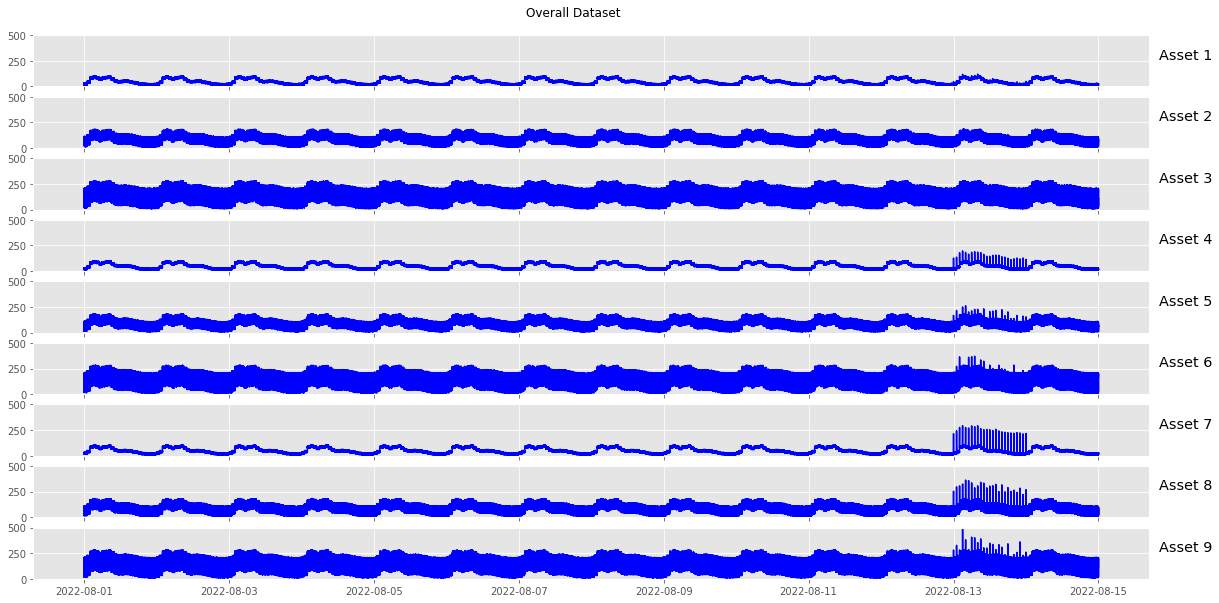

In [5]:
plot_dataset(dataset, 'Overall Dataset', 9)

#### Plot Abnormal range in dataset (in 3 days)

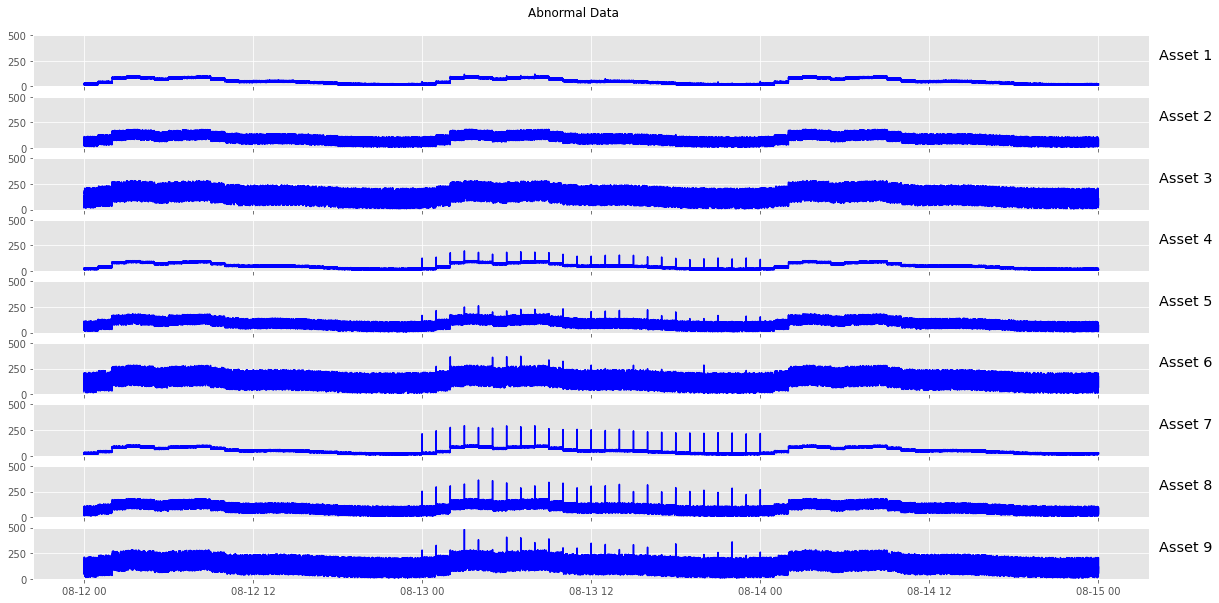

In [6]:
fig, axs = plt.subplots(nrows=n_asset, sharex=True)
fig.suptitle('Abnormal Data',y=0.92,x=0.5)
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(1,n_asset+1):
    focus_data = test_set[i][test_set[i]['datetime'] >= "2022-08-12"]
    x = focus_data['datetime']
    y = focus_data['n_request']
    axs[i-1].set_title(f'Asset {i}', ha='left', va='center',y=0.5,x=1.009)
    axs[i-1].set_ylim([0, 500])
    axs[i-1].plot(x, y, 'b-')
    
plt.show()

#### Plot Abnormal range in dataset (in 3 hours)

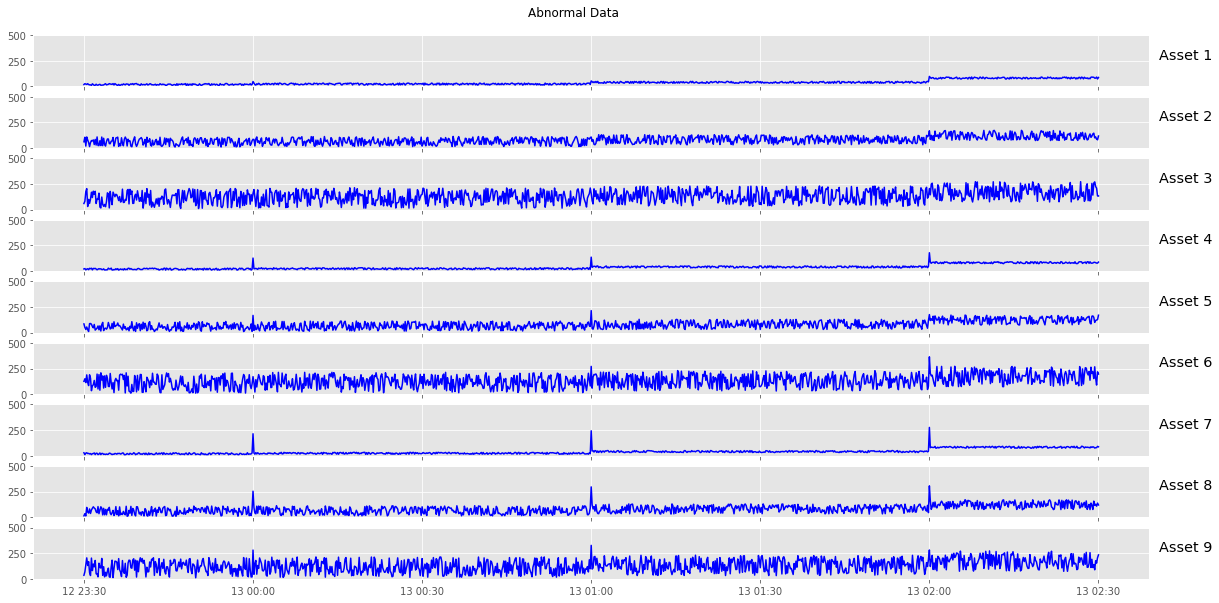

In [7]:
fig, axs = plt.subplots(nrows=n_asset, sharex=True)
fig.suptitle('Abnormal Data',y=0.92,x=0.5)
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(1,n_asset+1):
    focus_data = test_set[i][(test_set[i]['datetime'] >= "2022-08-12 23:30:00") & (test_set[i]['datetime'] <= "2022-08-13 02:30:00")]
    x = focus_data['datetime']
    y = focus_data['n_request']
    axs[i-1].set_title(f'Asset {i}', ha='left', va='center',y=0.5,x=1.009)
    axs[i-1].set_ylim([0, 500])
    axs[i-1].plot(x, y, 'b-')
    
plt.show()

## 2. Train Data

### 2.1 Define Function

In [10]:
def calculate_metric(y_true, y_pred):
    confusion_matrix_data = confusion_matrix(y_true, y_pred) # tn, fp, fn, tp
    TN, FP, FN, TP = confusion_matrix_data.ravel()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN/ (TN + FP)
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    
    if precision + recall == 0:
        F1 = 'devide by zero'
    else:
        F1 = 2 * precision * recall / (precision + recall)
        F1 = f'{F1:.4f}'
        
    result = {
        'confusion_matrix': confusion_matrix_data,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'accuracy': accuracy,
        'F1': F1,        
    }
    
    return result

In [41]:
def get_model_result(model_name):
    logger.info(f"{model_name}")               
    model_detail = {}    
    for i in range(5,5+1):
        logger.info(f'    asset {i}')
        
        keys = list(parameters[model_name].keys())
        values = parameters[model_name].values()
        all_combinations = list(itertools.product(*values))
        for parameter_value in all_combinations:
            parameter_result = {}
            for i_parameter in range(len(parameter_value)):
                parameter_result[keys[i_parameter]] = parameter_value[i_parameter]
                
            logger.info(f'           parameter_result {parameter_result}')    
            model =  model_classes[model_name](**parameter_result)        
            model.fit(train_set[i][['weekday', 'hour', 'n_request']].values)
            predict_result = model.predict(test_set[i][['weekday', 'hour', 'n_request']].values)
            test_set_tmp = test_set[i].copy(deep=True)
            test_set_tmp['predict'] = pd.Series(predict_result).apply(lambda x: 1 if (x == -1) else 0 )        

            y_true = test_set_tmp['abnormal']
            y_pred = test_set_tmp['predict']
            metric_result = calculate_metric(y_true, y_pred)
            print(f"             F1: {metric_result['F1']}")
            result = {
                "parameter": parameter_result,
                "metric_result": metric_result,
                "predict": test_set_tmp,
#                 "model": model,  # uncomment this line to save trained model in pickle
            }
            if i not in model_detail:
                model_detail[i] = []
            
            model_detail[i].append(result)
    return model_detail

### 2.2 Define hyperparameter of each model

In [11]:
model_details = {
    'isolation_forest': {},
    'local_outilier': {},
    'elliptic_envelope': {},
}

In [15]:
model_names = [
    'elliptic_envelope',
    'isolation_forest', 
    'local_outilier'
]

model_classes = {
    'isolation_forest': IsolationForest,
    'local_outilier': LocalOutlierFactor,
    'elliptic_envelope': EllipticEnvelope,
}

parameters = {
    'isolation_forest': {
        'n_estimators': np.linspace(1, 100, num=3, dtype='int'),
        'contamination': np.linspace(0.01, 0.5, num=10),   
    },
    'local_outilier': {
        'n_neighbors': np.linspace(1, 100, num=20, dtype='int'),
        'novelty': [True]
    },
    'elliptic_envelope': {
        'contamination': np.linspace(0.01, 0.5, num=10),         
    },
}

In [16]:
parameters['isolation_forest']['n_estimators']

array([  1,  50, 100])

### 2.3 Train Model

#### isolation_forest

In [48]:
model_name = 'isolation_forest'
model_details[model_name] = get_model_result(model_name)

2022-08-19 10:16:18 INFO     isolation_forest
2022-08-19 10:16:18 INFO         asset 5
2022-08-19 10:16:18 INFO                parameter_result {'n_estimators': 1, 'contamination': 0.01}
/tmp/ipykernel_477856/2622401338.py:4: RuntimeWarning:

invalid value encountered in long_scalars

2022-08-19 10:16:18 INFO                parameter_result {'n_estimators': 1, 'contamination': 0.06444444444444444}
2022-08-19 10:16:18 INFO                parameter_result {'n_estimators': 1, 'contamination': 0.11888888888888888}
2022-08-19 10:16:18 INFO                parameter_result {'n_estimators': 1, 'contamination': 0.17333333333333334}
2022-08-19 10:16:18 INFO                parameter_result {'n_estimators': 1, 'contamination': 0.22777777777777777}


             F1: nan
             F1: 0.0116
             F1: 0.0012
             F1: 0.0003


2022-08-19 10:16:18 INFO                parameter_result {'n_estimators': 1, 'contamination': 0.2822222222222222}
2022-08-19 10:16:18 INFO                parameter_result {'n_estimators': 1, 'contamination': 0.33666666666666667}
2022-08-19 10:16:18 INFO                parameter_result {'n_estimators': 1, 'contamination': 0.3911111111111111}
2022-08-19 10:16:18 INFO                parameter_result {'n_estimators': 1, 'contamination': 0.44555555555555554}


             F1: 0.0012
             F1: 0.0030
             F1: 0.0013
             F1: 0.0032


2022-08-19 10:16:18 INFO                parameter_result {'n_estimators': 1, 'contamination': 0.5}
2022-08-19 10:16:18 INFO                parameter_result {'n_estimators': 50, 'contamination': 0.01}


             F1: 0.0019
             F1: 0.0019


2022-08-19 10:16:19 INFO                parameter_result {'n_estimators': 50, 'contamination': 0.06444444444444444}


             F1: 0.0062


2022-08-19 10:16:20 INFO                parameter_result {'n_estimators': 50, 'contamination': 0.11888888888888888}


             F1: 0.0100


2022-08-19 10:16:20 INFO                parameter_result {'n_estimators': 50, 'contamination': 0.17333333333333334}


             F1: 0.0066


2022-08-19 10:16:21 INFO                parameter_result {'n_estimators': 50, 'contamination': 0.22777777777777777}


             F1: 0.0044


2022-08-19 10:16:22 INFO                parameter_result {'n_estimators': 50, 'contamination': 0.2822222222222222}


             F1: 0.0036


2022-08-19 10:16:23 INFO                parameter_result {'n_estimators': 50, 'contamination': 0.33666666666666667}


             F1: 0.0029


2022-08-19 10:16:24 INFO                parameter_result {'n_estimators': 50, 'contamination': 0.3911111111111111}


             F1: 0.0024


2022-08-19 10:16:25 INFO                parameter_result {'n_estimators': 50, 'contamination': 0.44555555555555554}


             F1: 0.0021


2022-08-19 10:16:26 INFO                parameter_result {'n_estimators': 50, 'contamination': 0.5}


             F1: 0.0018


2022-08-19 10:16:27 INFO                parameter_result {'n_estimators': 100, 'contamination': 0.01}


             F1: 0.0017


2022-08-19 10:16:28 INFO                parameter_result {'n_estimators': 100, 'contamination': 0.06444444444444444}


             F1: 0.0240


2022-08-19 10:16:30 INFO                parameter_result {'n_estimators': 100, 'contamination': 0.11888888888888888}


             F1: 0.0099


2022-08-19 10:16:32 INFO                parameter_result {'n_estimators': 100, 'contamination': 0.17333333333333334}


             F1: 0.0061


2022-08-19 10:16:34 INFO                parameter_result {'n_estimators': 100, 'contamination': 0.22777777777777777}


             F1: 0.0045


2022-08-19 10:16:36 INFO                parameter_result {'n_estimators': 100, 'contamination': 0.2822222222222222}


             F1: 0.0035


2022-08-19 10:16:38 INFO                parameter_result {'n_estimators': 100, 'contamination': 0.33666666666666667}


             F1: 0.0029


2022-08-19 10:16:39 INFO                parameter_result {'n_estimators': 100, 'contamination': 0.3911111111111111}


             F1: 0.0025


2022-08-19 10:16:41 INFO                parameter_result {'n_estimators': 100, 'contamination': 0.44555555555555554}


             F1: 0.0020


2022-08-19 10:16:43 INFO                parameter_result {'n_estimators': 100, 'contamination': 0.5}


             F1: 0.0019
             F1: 0.0016


#### local_outilier

In [43]:
model_name = 'local_outilier'
model_details[model_name] = get_model_result(model_name)

2022-08-19 10:14:48 INFO     local_outilier
2022-08-19 10:14:48 INFO         asset 5
2022-08-19 10:14:48 INFO                parameter_result {'n_neighbors': 1, 'novelty': True}
2022-08-19 10:14:48 INFO                parameter_result {'n_neighbors': 6, 'novelty': True}


             F1: 0.0314


2022-08-19 10:14:49 INFO                parameter_result {'n_neighbors': 11, 'novelty': True}


             F1: 0.0064


2022-08-19 10:14:50 INFO                parameter_result {'n_neighbors': 16, 'novelty': True}


             F1: 0.3651


2022-08-19 10:14:50 INFO                parameter_result {'n_neighbors': 21, 'novelty': True}


             F1: 0.9583


2022-08-19 10:14:51 INFO                parameter_result {'n_neighbors': 27, 'novelty': True}


             F1: 0.9583


2022-08-19 10:14:53 INFO                parameter_result {'n_neighbors': 32, 'novelty': True}


             F1: 0.9583


2022-08-19 10:14:58 INFO                parameter_result {'n_neighbors': 37, 'novelty': True}


             F1: 0.9583


2022-08-19 10:14:59 INFO                parameter_result {'n_neighbors': 42, 'novelty': True}


             F1: 0.9583


2022-08-19 10:15:00 INFO                parameter_result {'n_neighbors': 47, 'novelty': True}


             F1: 0.9583


2022-08-19 10:15:01 INFO                parameter_result {'n_neighbors': 53, 'novelty': True}


             F1: 0.9583


2022-08-19 10:15:03 INFO                parameter_result {'n_neighbors': 58, 'novelty': True}


             F1: 0.9362


2022-08-19 10:15:06 INFO                parameter_result {'n_neighbors': 63, 'novelty': True}


             F1: 0.9362


2022-08-19 10:15:07 INFO                parameter_result {'n_neighbors': 68, 'novelty': True}


             F1: 0.9362


2022-08-19 10:15:09 INFO                parameter_result {'n_neighbors': 73, 'novelty': True}


             F1: 0.9130


2022-08-19 10:15:10 INFO                parameter_result {'n_neighbors': 79, 'novelty': True}


             F1: 0.8889


2022-08-19 10:15:15 INFO                parameter_result {'n_neighbors': 84, 'novelty': True}


             F1: 0.8889


2022-08-19 10:15:17 INFO                parameter_result {'n_neighbors': 89, 'novelty': True}


             F1: 0.8889


2022-08-19 10:15:19 INFO                parameter_result {'n_neighbors': 94, 'novelty': True}


             F1: 0.8889


2022-08-19 10:15:22 INFO                parameter_result {'n_neighbors': 100, 'novelty': True}


             F1: 0.8889
             F1: 0.8889


#### elliptic_envelope

In [ ]:
model_name = 'elliptic_envelope'
model_details[model_name] = get_model_result(model_name)

## 3. save result

In [51]:
with open('output/model_details_ROC.pickle', 'wb') as handle:
    pickle.dump(model_details, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 4. Find Max F1 for each asset

#### F1 isolation_forest

In [135]:
F1_list = []
for i in range(1,n_asset+1):
    F1_list = []
    for asset_result in model_details['isolation_forest'][i]:
        try:
            F1 = float(asset_result['metric_result']['F1'])
        except Exception as e:
            F1 = 0

        F1_list.append(F1)
    print(f'     asset: {i}, F1 max : {max(F1_list)}, F1 of each hyper: {F1_list}')
    F1_list

     asset: 1, F1 max : 0.0025, F1 of each hyper: [0, 0.001, 0.0024, 0.0025, 0.0023, 0.002, 0.0017, 0.0017, 0.0018, 0.0014]
     asset: 2, F1 max : 0.0011, F1 of each hyper: [0, 0.0005, 0.0011, 0.0011, 0.001, 0.0011, 0.0009, 0.0008, 0.0007, 0.0007]
     asset: 3, F1 max : 0.0017, F1 of each hyper: [0, 0.0015, 0.0008, 0.0017, 0.0012, 0.0013, 0.0011, 0.0009, 0.0009, 0.0009]
     asset: 4, F1 max : 0.0468, F1 of each hyper: [0.0468, 0.0128, 0.0068, 0.0047, 0.0036, 0.0029, 0.0024, 0.0021, 0.0019, 0.0016]
     asset: 5, F1 max : 0.0295, F1 of each hyper: [0.0295, 0.0094, 0.0061, 0.0044, 0.0035, 0.0029, 0.0025, 0.0021, 0.0019, 0.0017]
     asset: 6, F1 max : 0.006, F1 of each hyper: [0.006, 0.003, 0.0035, 0.0026, 0.0023, 0.0019, 0.0016, 0.0014, 0.0013, 0.0011]
     asset: 7, F1 max : 0.0444, F1 of each hyper: [0.0444, 0.0128, 0.0069, 0.0048, 0.0036, 0.0029, 0.0024, 0.0021, 0.0018, 0.0017]
     asset: 8, F1 max : 0.0145, F1 of each hyper: [0.0145, 0.0126, 0.0068, 0.0047, 0.0036, 0.0029, 0.002

#### F1 local_outilier

In [139]:
for i in range(1,n_asset+1):
    F1_list = []
    for asset_result in model_details['local_outilier'][i]:
        try:
            F1 = float(asset_result['metric_result']['F1'])
        except Exception as e:
            F1 = 0

        F1_list.append(F1)
    print(f'     asset: {i}, F1 max : {max(F1_list)}, F1 of each hyper: {F1_list}')
    F1_list

     asset: 1, F1 max : 1.0, F1 of each hyper: [1.0, 0.8372, 0.75, 0.7179, 0.7179]
     asset: 2, F1 max : 0.0039, F1 of each hyper: [0.0039, nan, nan, nan, nan]
     asset: 3, F1 max : 0.0769, F1 of each hyper: [0.0012, 0.0769, 0.0769, 0.0769, 0.0769]
     asset: 4, F1 max : 1.0, F1 of each hyper: [1.0, 1.0, 1.0, 1.0, 1.0]
     asset: 5, F1 max : 0.9583, F1 of each hyper: [0.0314, 0.9583, 0.8889, 0.8889, 0.8889]
     asset: 6, F1 max : 0.4848, F1 of each hyper: [0.0038, 0.4848, 0.4848, 0.4848, 0.4848]
     asset: 7, F1 max : 1.0, F1 of each hyper: [1.0, 1.0, 1.0, 1.0, 1.0]
     asset: 8, F1 max : 1.0, F1 of each hyper: [0.0344, 1.0, 1.0, 1.0, 1.0]
     asset: 9, F1 max : 0.9362, F1 of each hyper: [0.0068, 0.9362, 0.9362, 0.9362, 0.9362]


#### F1 elliptic_envelope

In [20]:
F1_list = []
for i in range(1,n_asset+1):
    F1_list = []
    for asset_result in model_details['elliptic_envelope'][i]:
        try:
            F1 = float(asset_result['metric_result']['F1'])
        except Exception as e:
            F1 = 0

        F1_list.append(F1)
    print(f'     asset: {i}, F1 max : {max(F1_list)}, F1 of each hyper: {F1_list}')
    F1_list

     asset: 1, F1 max : 0.0027, F1 of each hyper: [0, 0.0027, 0.0015]
     asset: 2, F1 max : 0.0009, F1 of each hyper: [0, 0.0009, 0.0009]
     asset: 3, F1 max : 0.0013, F1 of each hyper: [0, 0.0013, 0.0009]
     asset: 4, F1 max : 0.0706, F1 of each hyper: [0.0706, 0.0032, 0.0017]
     asset: 5, F1 max : 0.0213, F1 of each hyper: [0.0213, 0.0031, 0.0017]
     asset: 6, F1 max : 0.0188, F1 of each hyper: [0.0188, 0.0019, 0.0012]
     asset: 7, F1 max : 0.0779, F1 of each hyper: [0.0779, 0.0032, 0.0017]
     asset: 8, F1 max : 0.0755, F1 of each hyper: [0.0755, 0.0032, 0.0017]
     asset: 9, F1 max : 0.0566, F1 of each hyper: [0.0566, 0.0032, 0.0017]
